In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
ba = pd.read_csv("../assets/bill_amount.csv",)
bid = pd.read_csv("../assets/bill_id.csv")
cd = pd.read_csv("../assets/clinical_data.csv")
demo = pd.read_csv("../assets/demographics.csv")

In [3]:
ba.isnull().sum()/ba.shape[0]
ba.dtypes
bid.isnull().sum()/bid.shape[0]
bid.dtypes

bill_id               int64
patient_id           object
date_of_admission    object
dtype: object

In [4]:
bid.date_of_admission = pd.to_datetime(bid.date_of_admission)

In [5]:
cd.date_of_admission = pd.to_datetime(cd.date_of_admission)
cd.date_of_discharge = pd.to_datetime(cd.date_of_discharge)

In [6]:
cd.medical_history_3.value_counts()

0      2176
No      761
1       348
Yes     115
Name: medical_history_3, dtype: int64

In [7]:
cd.medical_history_3 = cd.medical_history_3.map({"No":0, "Yes":1, "0":0, "1":1})

In [9]:
cd.dropna(inplace=True)
#change type to int
cd.medical_history_2 = cd.medical_history_2.astype('int')
cd.medical_history_5 = cd.medical_history_5.astype('int')

In [10]:
demo.date_of_birth = pd.to_datetime(demo.date_of_birth)
demo.gender.value_counts()

Female    1396
Male      1333
m          170
f          101
Name: gender, dtype: int64

In [11]:
demo.resident_status.value_counts()

Singaporean          1782
Singapore citizen     610
PR                    465
Foreigner             143
Name: resident_status, dtype: int64

In [12]:
demo.race.value_counts()

Chinese    1608
Malay       629
chinese     307
Indian      195
Others      161
India       100
Name: race, dtype: int64

In [13]:
demo.gender = demo.gender.apply(lambda x: "f" if x=="Female" else "m" if x=="Male" else x)
demo.resident_status = demo.resident_status.apply(lambda x: "Singaporean" if x=="Singapore citizen" else x)
demo.race = demo.race.apply(lambda x: "Chinese" if x=="chinese" else "Indian" if x=="India" else x)

In [14]:
bill_df = ba.merge(bid,on="bill_id").copy(deep=True)

In [15]:
cd.rename(columns={'id':'patient_id'}, inplace=True)

In [16]:
patient_df = cd.merge(demo,on="patient_id").copy(deep=True)

In [17]:
#let's make an age column from the birthdate
patient_df["age"] = pd.datetime.now().date() - patient_df["date_of_birth"]
#change timedelta dtype to years (int)
patient_df.age = patient_df["age"].apply(lambda x: x.days/365)

In [18]:
#make total_days from date of admission and discharge
patient_df["total_days"] = patient_df.apply(lambda x: (x["date_of_discharge"] - x["date_of_admission"]).days,axis=1)

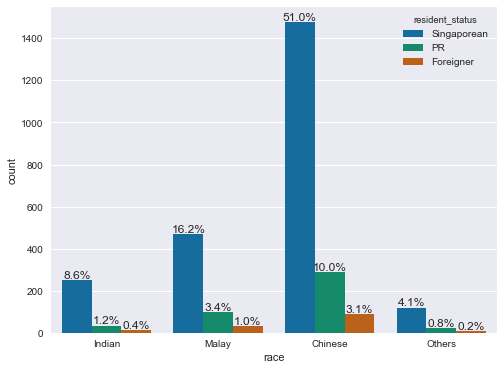

In [20]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x="race", data=patient_df, hue="resident_status",palette="colorblind")

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/len(patient_df)), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

In [21]:
df = bill_df.merge(patient_df,on=["patient_id","date_of_admission"])

In [22]:
df.shape

(11592, 34)

In [23]:
grp_df = pd.DataFrame(df.groupby(["patient_id","date_of_admission"]).amount.sum())
grp_df.reset_index(level=0,inplace=True)
grp_df["date_of_admission"] = grp_df.index

In [25]:
grp_df.shape

(2898, 3)

In [27]:
df = df.merge(grp_df,on=["patient_id","date_of_admission"]).copy(deep=True)
df.drop(["amount_x","bill_id"],axis=1,inplace=True)

In [29]:
df.drop_duplicates(inplace=True)
df.shape

(2898, 33)

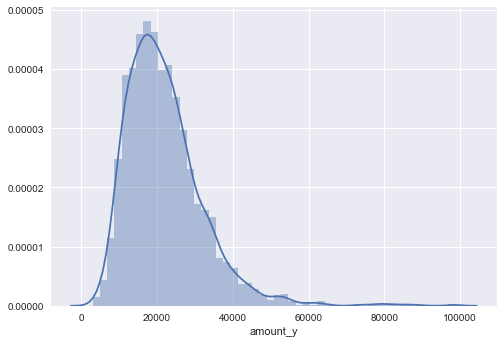

In [31]:
sns.distplot(df.amount_y)

In [33]:
df.amount_y.describe()

count     2898.000000
mean     21945.900495
std      10316.927624
min       2946.100354
25%      14887.246362
50%      20163.249584
75%      26810.081562
max      98723.854994
Name: amount_y, dtype: float64

In [38]:
df.groupby(["race","gender"]).amount_y.sum()

race     gender
Chinese  f         1.655249e+07
         m         1.889359e+07
Indian   f         3.545910e+06
         m         3.502913e+06
Malay    f         9.034322e+06
         m         8.858405e+06
Others   f         1.699766e+06
         m         1.511818e+06
Name: amount_y, dtype: float64

In [39]:
df.groupby(["race","resident_status"]).amount_y.sum()

race     resident_status
Chinese  Foreigner          3.194789e+06
         PR                 6.323568e+06
         Singaporean        2.592773e+07
Indian   Foreigner          5.041339e+05
         PR                 9.749733e+05
         Singaporean        5.569715e+06
Malay    Foreigner          1.777369e+06
         PR                 3.197507e+06
         Singaporean        1.291785e+07
Others   Foreigner          3.284786e+05
         PR                 5.710736e+05
         Singaporean        2.312031e+06
Name: amount_y, dtype: float64

In [38]:
df.groupby(df['date_of_admission'].map(lambda x: x.year))["resident_status"].value_counts()

date_of_admission  resident_status
2011               Singaporean        1904
                   PR                  360
                   Foreigner            88
2012               Singaporean        1776
                   PR                  320
                   Foreigner           112
2013               Singaporean        1852
                   PR                  348
                   Foreigner           104
2014               Singaporean        1860
                   PR                  388
                   Foreigner           116
2015               Singaporean        1868
                   PR                  364
                   Foreigner           132
Name: resident_status, dtype: int64

In [41]:
df["avg_bill"] = df["amount_y"]/df["total_days"]

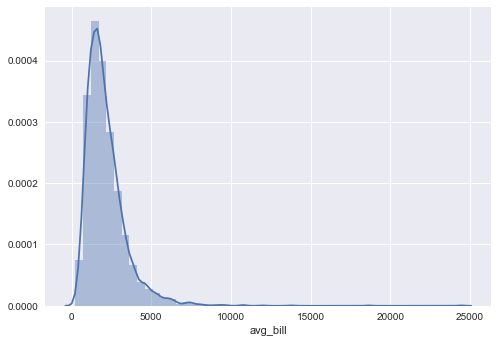

In [42]:
sns.distplot(df.avg_bill)

In [43]:
np.median(df.avg_bill)

1857.8490199728508

In [44]:
df.age.describe()

count    2898.000000
mean       55.863354
std        14.634211
min        26.000000
25%        43.000000
50%        54.000000
75%        68.000000
max        87.000000
Name: age, dtype: float64

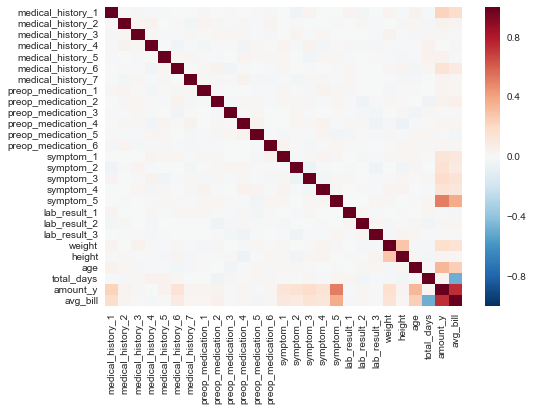

In [45]:
sns.heatmap(df.corr())

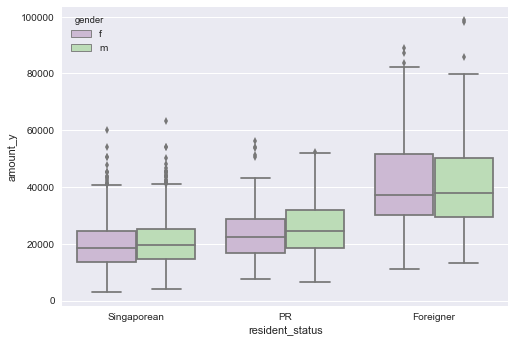

In [47]:
sns.boxplot(x="resident_status", y="amount_y", hue="gender", data=df, palette="PRGn")

In [48]:
df.groupby("race").avg_bill.median()

race
Chinese    1653.262664
Indian     2151.929226
Malay      2590.745653
Others     1952.650854
Name: avg_bill, dtype: float64

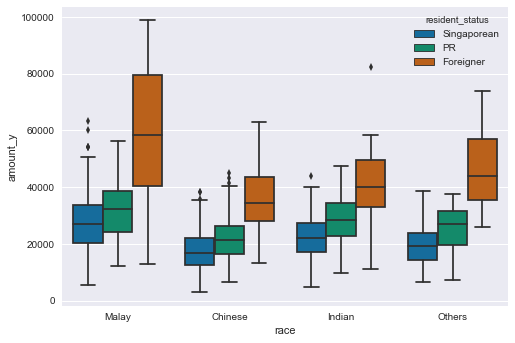

In [49]:
sns.boxplot(x="race", y="amount_y", hue="resident_status", data=df, palette="colorblind")

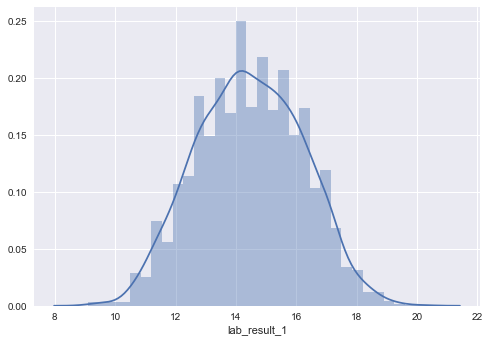

In [50]:
sns.distplot(df.lab_result_1)

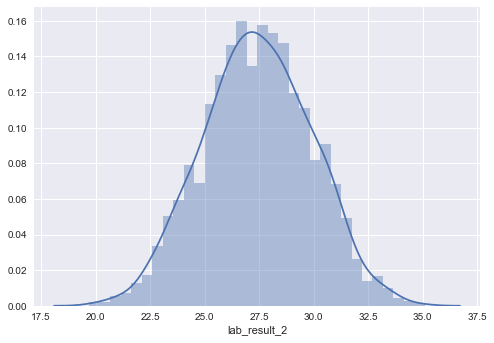

In [51]:
sns.distplot(df.lab_result_2)

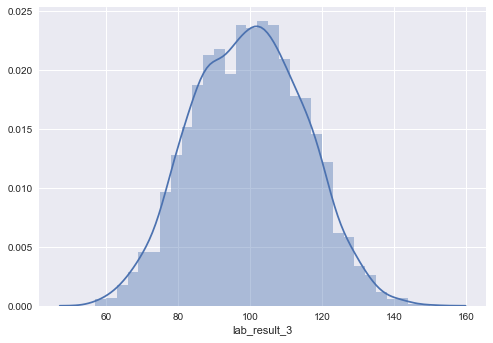

In [52]:
sns.distplot(df.lab_result_3)

In [53]:
df.medical_history_1.value_counts()/len(df)

0    0.828502
1    0.171498
Name: medical_history_1, dtype: float64

In [54]:
df.medical_history_2.value_counts()/len(df)

0.0    0.68254
1.0    0.31746
Name: medical_history_2, dtype: float64

In [55]:
df.medical_history_3.value_counts()/len(df)

0    0.862664
1    0.137336
Name: medical_history_3, dtype: float64

In [56]:
df.medical_history_4.value_counts()/len(df)

0    0.94548
1    0.05452
Name: medical_history_4, dtype: float64

In [57]:
df.medical_history_5.value_counts()/len(df)

0.0    0.935128
1.0    0.064872
Name: medical_history_5, dtype: float64

In [58]:
df.medical_history_6.value_counts()/len(df)

0    0.743616
1    0.256384
Name: medical_history_6, dtype: float64

In [59]:
df.medical_history_7.value_counts()/len(df)

0    0.746032
1    0.253968
Name: medical_history_7, dtype: float64

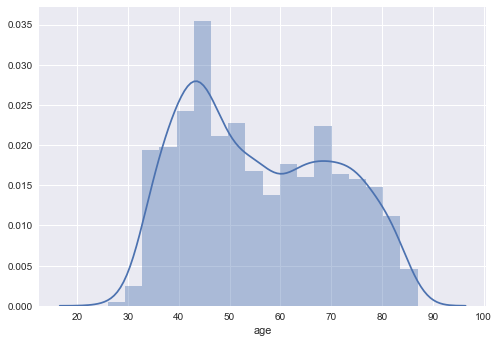

In [60]:
sns.distplot(df.age)

In [61]:
np.mean(df.age)

55.86335403726708

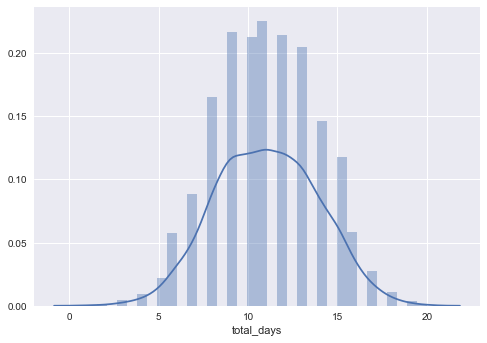

In [62]:
sns.distplot(df.total_days)

In [63]:
np.mean(df.total_days)

11.045893719806763

In [64]:
df["total_mh"] = df["medical_history_1"] + df["medical_history_2"] + df["medical_history_3"] + df["medical_history_4"] + df["medical_history_5"]+ df["medical_history_6"] + df["medical_history_7"]

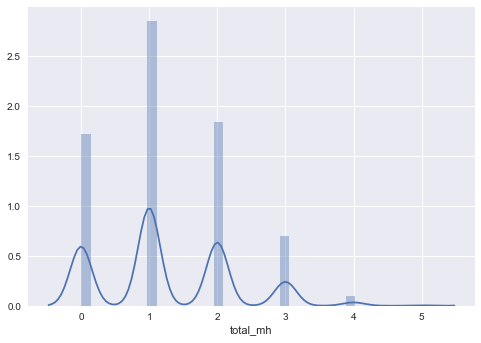

In [65]:
sns.distplot(df.total_mh)

In [66]:
df["total_sym"] = df["symptom_1"] + df["symptom_2"] + df["symptom_3"] + df["symptom_4"] + df["symptom_5"]

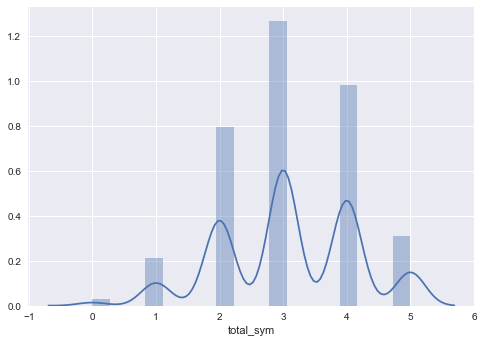

In [67]:
sns.distplot(df.total_sym)

In [72]:
from sklearn.cross_validation import train_test_split,cross_val_score,StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import roc_curve, auc

In [ ]:
def score(model, name, myX,myy):
    s = cross_val_score(model, myX, myy, cv=cv,scoring="")
    print "{} Score:\t{:0.3} Â± {:0.3}".format(name, s.mean().round(3), s.std().round(3))

In [ ]:
def fitAndPrint(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print "Accuracy Score: %s"%(accuracy_score(y_test,y_pred))

In [ ]:
le = LabelEncoder()